# Evaluating your classifier

So we know how to fit some models and check out what they are doing
by looking at how they carve up the space to gain some understanding
from it but what kind of objective measures do we have to understand
how well our models are performing? Let's find out!

## So what's available

Remember we are working with binary classification which is quite a specific subset of
machine learning and has lots of interesting metrics associated with it.

Let's go on a little journey here starting with intuition.

In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns


%matplotlib inline

Let's create ourselves a balanced dataset.
Balanced means: both classes have the same number of observations.

So let's generate a silly little dataset to focus on some concepts:

In [142]:
# target is True if x >= 50 and False if x < 50
# 0-49 = False and 50-99 = True
df = pd.DataFrame({
    'x': list(range(0, 100)),
    'target': [True if x >= 50 else False for x in range(0, 100)]
}) 

In [143]:
print('# Trues: {}, # Falses: {}'.format(df.target.sum(), (~df.target).sum()))

# Trues: 50, # Falses: 50


In [144]:
df.head()

,target,x
0,False,0
1,False,1
2,False,2
3,False,3
4,False,4


Let's create a really stupid model that predicts True or False based
upon a few different ranges:

In [158]:
# Here is my super stupid model
def my_stupid_model(x):
    return x > 30 and x < 65

preds = df.x.map(my_stupid_model)

So given that (in binary classification) and your job is to identify if something is
in the "true" class, a first intuition might be to say "how many predictions did I
get right compared to how many I got wrong?"

Let's find out!

In [159]:
(df.shape[0] - (preds ^ df.target).sum()) / df.shape[0]

0.46000000000000002

Okay, that's cool. It looks like we've got a stupid model, just like we knew before.

However, things get worse! we can game this system with an even stupider model without
much effort at all if we have an inbalanced dataset. Like the following:

In [160]:
# target is True if 45 < x < 50
# 46-49 = True and all else = False
df = pd.DataFrame({
    'x': list(range(0, 100)),
    'target': [True if 45 <= x <= 50 else False for x in range(0, 100)]
}) 

In [161]:
# wow, really dumb, always returns the same thing!
def my_really_dumb_model(x):
    return False

preds = df.x.map(my_really_dumb_model)

In [162]:
(df.shape[0] - (preds ^ df.target).sum()) / df.shape[0]

0.93999999999999995

Boom! 93% FTFW! We are so smart! 🤓

Not really, what we are finding out here is that there are some problems with
the measurement we are using.

This measurement we are using here has has a name: it is called `accuracy` and it's implemented in scikit
so we can use it all we want!

In [163]:
from sklearn.metrics import accuracy_score
accuracy_score(df.target, preds)

0.93999999999999995

However, there's definitely problems with using accuracy, especially if we are working with
an imbalanced dataset. We need to start a deeper dive here and start exploring
a few different concepts in our journey to arriving at a more robust way to look
at our binary classifier.

Let's bring back the original dataset and model:

In [156]:
# target is True if x >= 50 and False if x < 50
# 0-49 = False and 50-99 = True
df = pd.DataFrame({
    'x': list(range(0, 100)),
    'target': [True if x >= 50 else False for x in range(0, 100)]
}) 

def my_stupid_model(x):
    return x > 45 and x < 65

preds = df.x.map(my_stupid_model)

First let's get some terminology down:

1) tp - true positive
    - the number of observations you labeled as "true" that are actually "true"
    - great job! you said they were "true" and they actually were!
2) fp - false positive
    - the number of observations you labeled as "true" that were actually "false"
    - not so great job ☹️, you said they were "true" but you were wrong... false alarm! fake news!
    
Alright, we've got a few concepts to work with here. Notice the second part of the phrase
is called "p" which stands for "positive". So this means that you are only looking at
the subset of your predictions that you classified as "true".

For a concrete example, let's say that you guessed that any observations
in our dataset that have values above 40 and below 55 should be considered "true"
while everything else is false:

Alright, let's see how many observations we classified as "true"

In [44]:
# now we've got 100 observations and 14 of them the model
# predicted "true" for.
len(preds), preds.sum()

(100, 19)

That gives us a grand total of 14 observations that we are considering "true".

We can check on each of the true positive and false positive rates because we
have the "target" which is the actual real deal.

In [45]:
# grab the subset of "target" that we predicted "true" for
all_true = df.loc[preds]
all_true

,target,x
46,False,46
47,False,47
48,False,48
49,False,49
50,True,50
51,True,51
52,True,52
53,True,53
54,True,54
55,True,55


As you can see, not all of the observations in target are actually "true". This means that we have
some false positives and some false true positives!

In [46]:
# alright, now let's check out how many true positives we have
all_true.target.sum()

15

Hooray! Of the ones that our model predicted as "true", 9 of them actually are! That's great!

Now let's take a look at our false alarms.

In [47]:
# Let's invert the target and then do a sum to get the false positives
(~all_true.target).sum()

4

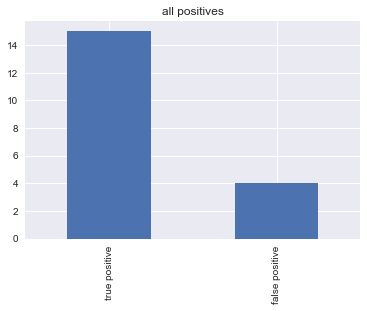

In [48]:
# In summary
pd.Series([all_true.target.sum(), (~all_true.target).sum()], index=['true positive', 'false positive']).plot.bar(
    title='all positives')

Word up! Or down. Not sure. Of the observations we picked as "true" we got 5 wrong ☹️

Alright, let's put this together now into a ratio so we can get an idea of how many
of our "true" guesses were correct in a relative sense:

In [49]:
all_true.target.sum() / all_true.shape[0]

0.78947368421052633

Hm, this doesn't seem so bad at all! This is something you might be happy to live with.

And it seems like something useful to know! I wonder if it has a name?

## It has a name! It's called precision!

And it's in scikit! Behold the glory 🎉

In [50]:
from sklearn.metrics import precision_score
precision_score(df.target, preds)

0.78947368421052633

One more time, just to make sure it's clear:

In [51]:
manually_calculated = all_true.target.sum() / all_true.shape[0]
from_scikit = precision_score(df.target, preds)

print('manually calculated precision: {}\nPrecision from scikit:         {}'.format(
    manually_calculated, from_scikit))

manually calculated precision: 0.7894736842105263
Precision from scikit:         0.7894736842105263


Well then, now we're getting somewhere. We've got this super duper metric that is already
in scikit and we've got a model that is performing crazy good at 73%.

Who needs machine learning!

## Let's think more critically now

I'm sure that some of you by now have noticed what's wrong with this picture.

We made 100 predictions and we are only evaluating ourselves on a tiny little
portion of the predictions that we made! Now that's not fair!

I'm sure that you can see why, but let's take it to a bit more extreme
with an even dumber model:

In [52]:
# This model has totally given up on life
def my_stupid_model(x):
    return x == 99

preds = df.x.map(my_stupid_model)
precision_score(df.target, preds)

1.0

Well if you never take a chance, of course you will never fail!

It's time to grow a pair and start looking at the rest of our predictions. 

This gets us into the the next category which is the ones that we predicted
"false" for.

- tn - true negative
    - these are the observations you predicted "false" for and were actually "false"
    - nice job! you said they were "false" and you were actually right about it!
- fn - false negative
    - these are the observations you predicted "false" for and were actually "true"
    - not so great job. you threw some babies out with the bath water 👶 !
    
Let's bring back our original stupid model model and look at some of these numbers



In [53]:
def my_stupid_model(x):
    return x > 45 and x < 65

preds = df.x.map(my_stupid_model)

In [54]:
all_false = df.loc[~preds]

Let's see how are are doing in the true negative department:

In [55]:
(~all_false.target).sum()

46

Now let's see what's up in the false negative department

In [56]:
all_false.target.sum()

35

Summarize:

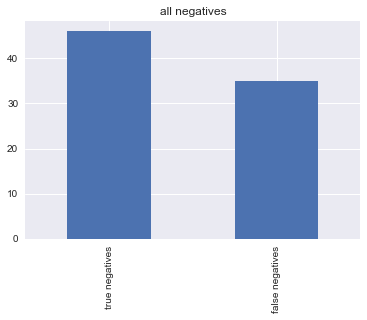

In [57]:
pd.Series([(~all_false.target).sum(), all_false.target.sum()], index=['true negatives', 'false negatives']).plot.bar(
    title='all negatives')

In [58]:
# now the ratio

(~all_false.target).sum() / all_false.shape[0]

0.5679012345679012

Yikes! Things are not looking so good now! Of the ones we predicted "false" for,
there's a LOT of them that are not False at all!

Plus, we classified a lot more as false than as true:

In [59]:
print('# True predictions: {}, # False predictions: {}'.format(preds.sum(), (~preds).sum()))

# True predictions: 19, # False predictions: 81


Alright, by now we are understanding that we need a bit more of a global
view on things when we are evaluating our model so the next thing we
might ask ourselves is just: how well did my model do at finding all
of the "trues". That way we break out of the problems we were running into
by only considering subsets of the data that our model made predictions on.

Alright, so let's find out how many of the "trues" our model was able to track down:

In [60]:
(df.target & preds).sum() / df.target.sum()

0.29999999999999999

And of course, this one is in scikit as well

In [61]:
from sklearn.metrics import recall_score
recall_score(df.target, preds)

0.29999999999999999

Oh man, the more objective we get about this model, the worse it gets!

Obviously we need to be working toward getting ourselves to a number
that expresses our models performance much better. Maybe we can average
our precision for both classes?

In [62]:
(precision_score(df.target, preds) + precision_score(~df.target, ~preds)) / 2

0.67868745938921382

Maybe try the same for recall?

In [63]:
(recall_score(df.target, preds) + recall_score(~df.target, ~preds)) / 2

0.60999999999999999

Now it seems like we are getting somewhere but it doesn't seem quite right still. It still
allows us to be weighted down by one of the classes that doesn't have a lot of samples
in it, right?

Consider the other really, REALLY stupid model again:

In [64]:
def gave_up_on_life(x):
    return x == 99

stupid_preds = df.x.map(gave_up_on_life)
(precision_score(df.target, stupid_preds) + precision_score(~df.target, ~stupid_preds)) / 2

0.7525252525252526

In [65]:
(recall_score(df.target, stupid_preds) + recall_score(~df.target, ~stupid_preds)) / 2

0.51000000000000001

That's just not fair! Sure we are taking both classes into account but grrrr,
we just can't get there!

At this point, it's obvious that we need to do some kind of weighted average between
something. And it turns out that the f1_score can help us with this.

The scikit documentation says `The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0.`

In [66]:
from sklearn.metrics import f1_score
f1_score(df.target, stupid_preds)

0.039215686274509803

In [67]:
f1_score(df.target, preds)

0.43478260869565211

Alright, now that we are getting somewhere, let's take a break to get the big picture under control.

We have these concepts of true and false positive and negatives. This can be expressed as a 2X2
matrix where each index corresponds to one of the concepts we have learned:

In [68]:
from sklearn.metrics import confusion_matrix

confusion_matrix(df.target, preds)

array([[46,  4],
       [35, 15]])

It's not super easy to read but this gives us the true negatives in C_{0,0}, false negatives in C_{1,0}, true positives in C_{1,1} and false positives in C_{0,1}.

A cool way to visualize this is with a heatmap:

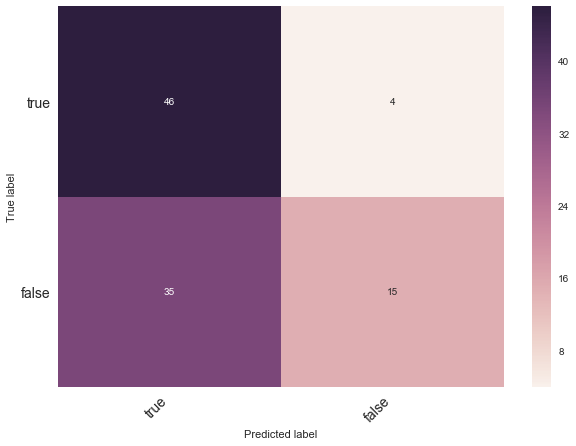

In [87]:
from draw_confusion import draw_confusion_matrix

draw_confusion_matrix(confusion_matrix(df.target, preds))

And at this point we have a decent way to visualize a few key metrics as well
as get a global view of how well our model is behaving.

However, binary classifiers aren't just required to respond "yes" or "no" but
very often are required to give us an idea of how confident they are in their
prediction. 

Said another way: don't just tell me yes or no, tell me *how likely* it is to
be a yes or no.

Now a model is required to produce a number between 0 and 1 in which we would
like to interpret as:

- Closer to `0`, the more likely you are to be in the "False" class
- Closer to `1`, the more likely you are to be in the "True" class

Let's fire up another dumb model that does this for us:

In [97]:
# just returns the value of x itself. So the closer you
# are to 100, the more probable it is you are a "1"
def dumb_proba_model(x):
    return x / 100

probas = df.x.map(dumb_proba_model)

Now what we have with a model that gives us probabilities rather
than just a 0 or 1 is a way to rank observations as more or less
likely to be in a particular class. This is cool!

However, this now raises an interesting question about when we
call an observation "True" or "False". If we need a straight
answer out of our model and not some wishy-washy answer in probabilities
then we will need to select a *cutoff threshold*.

This is exactly what it sounds like! You will need to select
a cutoff in which everything above that cutoff is considered "True"
and everything below it is considered "False". Once you have done
this, you will end up with an array of Trues and Falses that
you can then derive your confusion matrix from

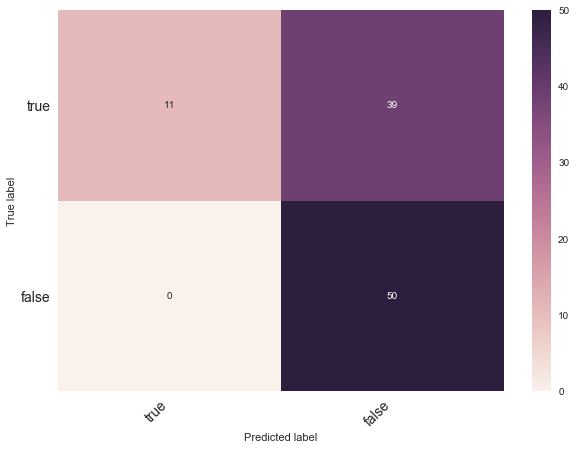

In [98]:
threshold = 0.1
draw_confusion_matrix(confusion_matrix(df.target, probas.map(lambda x: x > threshold)))

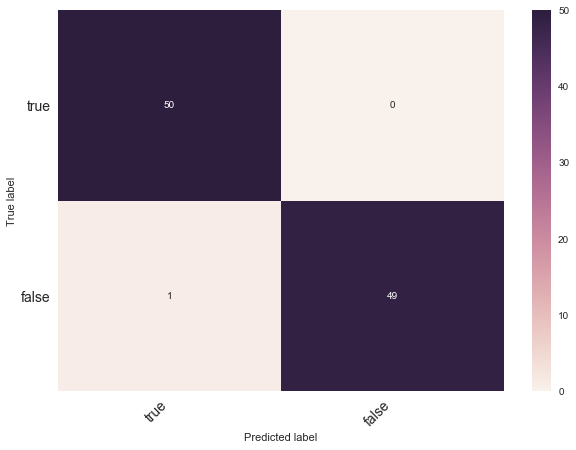

In [99]:
threshold = 0.5
draw_confusion_matrix(confusion_matrix(df.target, probas.map(lambda x: x > threshold)))

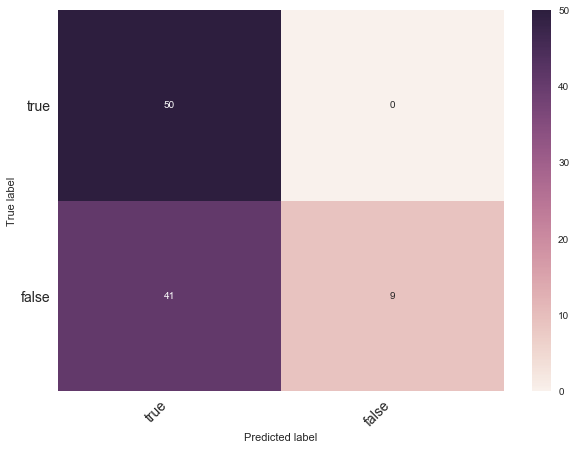

In [100]:
threshold = 0.9
draw_confusion_matrix(confusion_matrix(df.target, probas.map(lambda x: x > threshold)))

Alright, now we've got a new problem. We can see how our model is doing
in a few different ways. But now we have this crazy issue in which we have
an entire analysis that we can do for any threshold that we may want to pick!

Gaaaahhhh! Can it just please be simple!

Well not really. What you will need to do now is to figure out a decent
way to visualize your model that given some probas. On to your exercise, young grashopper!